In [1]:
import math
from bprH import bprH, adv_index, save_model, load_model
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
import cProfile as profile

%load_ext autoreload
%autoreload 2

In [2]:
def behavior_generator(num_user = 10, num_item=10):
    data = []
    for u in range(num_user):
        for i in range(num_item):
            p = np.random.uniform(0,1)
            if 0.7 <= p:
                data.append(['U' + str(u),'I' + str(i),'P'])
                data.append(['U' + str(u),'I' + str(i),'V'])
            elif 0.3 <= p:
                data.append(['U' + str(u),'I' + str(i),'V'])
    data = pd.DataFrame(data, columns=['UserID', 'ItemID', 'Action'])
    return data

In [3]:
data = behavior_generator(num_user=20, num_item=20)

In [4]:
# the best way is to split the data with a time manner - from sklearn.model_selection import TimeSeriesSplit
# but first let's do it in a simple way

original_item_list = sorted(set(data.ItemID))
original_user_list = sorted(set(data.UserID))

data_without_target = data[data.Action != 'P']
data_only_with_target = data[data.Action == 'P']

In [6]:
# split the data_only_with_target into 5 folds
kf = KFold(n_splits=2,shuffle=True, random_state=0)
kf.get_n_splits(X=data_only_with_target)

2

In [8]:
#pr = profile.Profile()
#pr.disable()

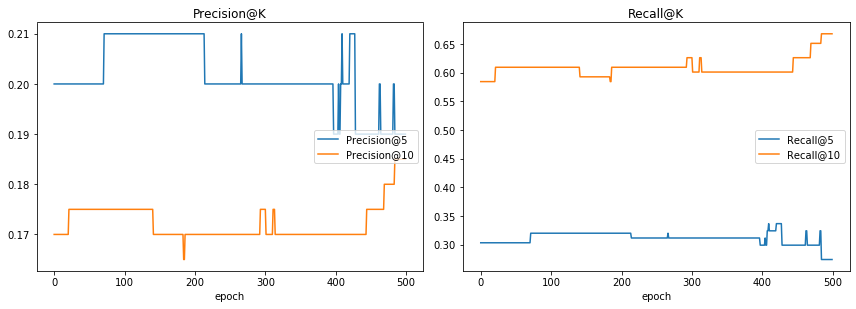

Precision@K
	Precision@5      	 (min:    0.190, max:    0.210, cur:    0.190)
	Precision@10     	 (min:    0.165, max:    0.185, cur:    0.185)
Recall@K
	Recall@5         	 (min:    0.274, max:    0.337, cur:    0.274)
	Recall@10        	 (min:    0.584, max:    0.668, cur:    0.668)


100%|██████████| 500/500 [03:44<00:00,  2.56it/s, loss=-4.38, norm_nabula_U_u=2.39, norm_nabula_Vi=1.48, norm_nabula_Vj=0.21, norm_nabula_Vk=0.405, precision_10=0.185, precision_5=0.19, recall_10=0.668, recall_5=0.274]


In [7]:
#pr.enable()
cnt = 0
for train_index, test_index in kf.split(X=data_only_with_target):
    # build train and test data
    # page 90 5.2 section - make most of auxiliary data in training process
    train_data = pd.concat([data_only_with_target.iloc[train_index], data_without_target])
    test_data = data_only_with_target.iloc[test_index]

    # start a BPRH model
    model = bprH(dim=5, omega=8, rho=1, lambda_u=1, lambda_v=0.5, lambda_b=0.5, gamma=0.01, random_state=20200704, num_iter=500)

    model.fit(X=train_data, eval_X=test_data, original_item_list=original_item_list, original_user_list=original_user_list,
              saved_path='data/item-set-coselection-'+str(cnt)+'.pkl', coselection=True, plot_metric=True)
    cnt += 1

#pr.dump_stats('profile.pstat')

In [12]:
# read sobazaar data
data = pd.read_csv('data/sb_unique_actions_20.csv')
# change column name
data.columns = ['ItemID', 'UserID', 'Action', 'Action_Date', 'Action_Time',
       'SessionID']

# data = data.sample(frac=0.5) # TODO: test small data

In [13]:
# the best way is to split the data with a time manner - from sklearn.model_selection import TimeSeriesSplit
# but first let's do it in a simple way

original_item_list = sorted(set(data.ItemID))
original_user_list = sorted(set(data.UserID))

data_without_target = data[data.Action != 'P']
data_only_with_target = data[data.Action == 'P']

In [14]:
# split the data_only_with_target into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(X=data_only_with_target)

5

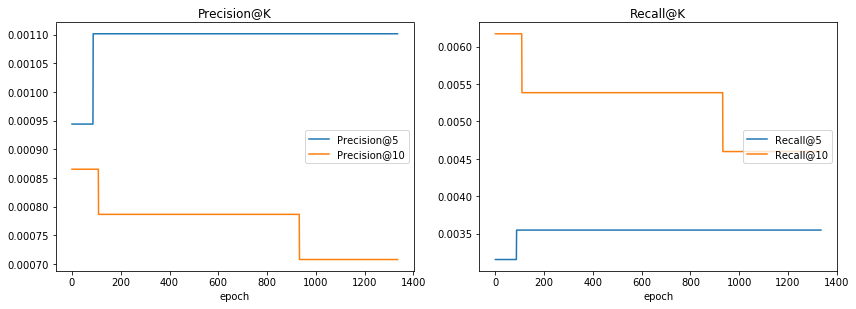

Precision@K
	Precision@5      	 (min:    0.001, max:    0.001, cur:    0.001)
	Precision@10     	 (min:    0.001, max:    0.001, cur:    0.001)
Recall@K
	Recall@5         	 (min:    0.003, max:    0.004, cur:    0.004)
	Recall@10        	 (min:    0.005, max:    0.006, cur:    0.005)


 13%|█▎        | 1336/10000 [8:42:02<60:05:13, 24.97s/it, loss=-17.4, norm_nabula_U_u=13.5, norm_nabula_Vi=5.07, norm_nabula_Vj=6.85, norm_nabula_Vk=6.98, precision_10=0.000708, precision_5=0.0011, recall_10=0.0046, recall_5=0.00355]

In [ ]:
cnt = 0
for train_index, test_index in kf.split(X=data_only_with_target):
    # build train and test data
    train_data = pd.concat([data_only_with_target.iloc[train_index], data_without_target])
    test_data = data_only_with_target.iloc[test_index]

    # start a BPRH model
    model = bprH(dim=30, omega=1000, rho=1, lambda_u=1, lambda_v=0.5, lambda_b=0.5, gamma=0.01, random_state=20200704, num_iter=10000)

    model.fit(X=train_data, eval_X=test_data, original_item_list=original_item_list, original_user_list=original_user_list,
              saved_path='data/item-set-coselection-'+str(cnt)+'.pkl', coselection=True, plot_metric=True)
    cnt += 1

In [13]:
# test recommendation
# build the rec list for users
user_rec_dict = dict()

# print("Build User's Purchased Item Dict & Rec List")
# user_set_bar = tqdm(user_to_recommend)
for u in [0]:
    user_rec_dict[u] = set()
    est_pref_of_u = np.array([0.12,0.33,0.49,0.55,0.26,0.11,0.89,0.98])
    #
    est_pref_sort_index = est_pref_of_u.argsort()[::-1]
    rec_item_cnt = 0
    for item_id in est_pref_sort_index:
        if rec_item_cnt == 5:
            break
        if item_id not in set([6,7]):
            user_rec_dict[u].add(item_id)
            rec_item_cnt += 1


In [14]:
scoring_list = []
# test metric
for u in [0]:
    rec_list_for_user_u = user_rec_dict[u]
    ground_truth_for_user_u = set([3,1])
    precision_K_for_u = len(rec_list_for_user_u.intersection(ground_truth_for_user_u)) / 5
    recall_K_for_u = len(rec_list_for_user_u.intersection(ground_truth_for_user_u)) / len(
        ground_truth_for_user_u) if len(ground_truth_for_user_u) != 0 else np.nan
    scoring_list.append([u, precision_K_for_u, recall_K_for_u])
#scoring_list = pd.DataFrame(scoring_list, columns=['UserID', 'Precision@' + str(K), 'Recall@' + str(K)])
#precision_K = scoring_list.mean()['Precision@' + str(K)]
#recall_K = scoring_list.mean()['Recall@' + str(K)]
scoring_list = np.array(scoring_list)
scoring_average = scoring_list.mean(axis=0)
precision_K = scoring_average[1]
recall_K = scoring_average[2]

In [3]:
est_pref_of_u = [1,2,3,4,-1,-2,-3,-4]
E_u = 0
indicator_cnt = 0
for i in [0,1,2]:
    for j in [3,4,5,6,7]:
        E_u += 1
        if est_pref_of_u[i] > est_pref_of_u[j]:
            indicator_cnt += 1
auc_for_u = indicator_cnt / E_u if E_u != 0 else 0